# Upstart Data Challenge


In this problem, you will forecast the outcome of a portfolio of loans. Each loan is scheduled to be repaid over 3 years and is structured as follows:
* First, the borrower receives the funds. This event is called origination.
* The borrower then makes regular repayments, until one of the following
happens:
  * The borrower stops making payments, typically due to financial
hardship, before the end of the 3-year term. This event is called
charge-off, and the loan is then said to have charged off.
  * The borrower continues making repayments until 3 years after the
origination date. At this point, the debt has been fully repaid.

In the attached CSV, each row corresponds to a loan, and the columns are defined as follows:
* The column with header days since origination indicates the number of days that elapsed between origination and the date when the data was collected.
* For loans that charged off before the data was collected, the column with header days from origination to charge-off indicates the number of days that elapsed between origination and charge-off. For all other loans, this column is blank.

We would like you to estimate what fraction of these loans will have charged off by the time all of their 3-year terms are finished. Please include a rigorous explanation of how you arrived at your answer, and include any code you used. You may make simplifying assumptions, but please state such assumptions explicitly. Feel free to present your answer in whatever format you prefer; in particular, PDF and Jupyter Notebook are both fine. Also, we expect that this project will not take more than 3-6 hours of your time.

We’ve taken time and thought to develop this problem in such a way that it will be useful for our screenings. We ask that you keep it confidential and not share it with others. And please do not solicit help from others when working on it – your solution should be your own.

Last, we hope you find the problem interesting! It is representative of real problems we work on at Upstart.

# Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

df_loan = pd.read_csv('loan_timing.csv')
df_loan.head()

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN


### Check data

In [2]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
days since origination                50000 non-null int64
days from origination to chargeoff    3305 non-null float64
dtypes: float64(1), int64(1)
memory usage: 781.3 KB


From the summary we know that there are 3305 loans having charged off among 50000 loans. After their 3-year terms finished, there should be more loans having charged off.

In [3]:
den = df_loan['days since origination'].count()
num = df_loan['days from origination to chargeoff'].count()
current_fraction = float(num) / den * 100.
print('The current fraction of loans having charged off is %.2f%%' % current_fraction)

The current fraction of loans having charged off is 6.61%


In [4]:
df_loan.describe()

,days since origination,days from origination to chargeoff
count,50000.000000,3305.000000
mean,365.844760,214.852345
std,210.965114,165.233874
min,0.000000,0.000000
25%,183.000000,76.000000
50%,366.000000,180.000000
75%,549.000000,323.000000
max,730.000000,725.000000


From the statistical table, we notice the largest value in the 'days since origination' column is 730. Because 730 days are equivalent to 2 years exactly (730 / 365 = 2), we know none of loans finished their 3-year term. We need to estimate how many loan will have chargeoff in their third year if they don't have chargeoff within the first 2 years.

### Check distributions

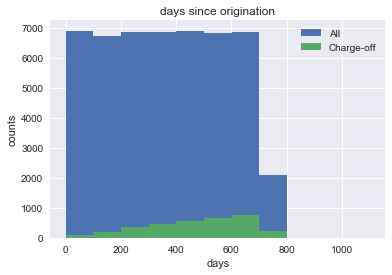

In [5]:
all_loans = df_loan['days since origination']

charged_off = df_loan['days from origination to chargeoff'].notnull()
df_chargedoff = df_loan[charged_off]
all_chargedoff = df_chargedoff['days since origination']

#sns.distplot(all_loans)
#plt.show()

#sns.distplot(all_chargedoff)
#plt.show()

# Use 100 days per bin
# 3 years = 1095 days corresponding to bin 1000 days to 1100 days
plt.hist(all_loans, bins=11, range=(0, 1101), label='All')
plt.hist(all_chargedoff, bins=11, range=(0, 1101), label='Charge-off')
plt.xlabel('days')
plt.ylabel('counts')
plt.title('days since origination')
plt.legend()
plt.show()

A lot of loans having charged off are in their 600 to 700 days.

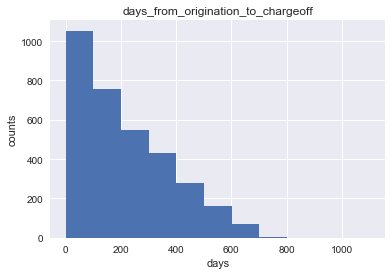

In [6]:
plt.hist(df_chargedoff['days from origination to chargeoff'], bins=11, range=(0, 1101))
plt.xlabel('days')
plt.ylabel('counts')
plt.title('days_from_origination_to_chargeoff')
plt.show()

A lot of loans get charged off in their first 100 days and the number of loans with charge-off decreases with time.

I prefer to use underscore in the column names.

In [7]:
df_loan.rename(columns={'days since origination':'days_since_origination',
                        'days from origination to chargeoff':'days_from_origination_to_chargeoff'},
               inplace=True) 

### Add new columns
* Since each loan has to be repaid over 3 years, we first calculate how many days are left when the data was collected.
  * And put the results into the `remaining_days` column.
  * 3 years = 3 * 365 = 1095 days
* Add a new column which counts the days that elapsed between charged-off and the date when the data was collected.
  * `days_from_charged_off` column.
  * If there is no charge-off, then set to zero.

In [8]:
df_loan['remaining_days'] = 3 * 365 - df_loan['days_since_origination']
df_loan['days_from_charged_off'] = df_loan['days_since_origination'] - df_loan['days_from_origination_to_chargeoff']
df_loan['days_from_charged_off'].fillna(0, inplace=True)
df_loan.head()

,days_since_origination,days_from_origination_to_chargeoff,remaining_days,days_from_charged_off
0,109,NaN,986,0.0
1,679,NaN,416,0.0
2,723,NaN,372,0.0
3,509,NaN,586,0.0
4,254,NaN,841,0.0


If the loan didn't get charged off when data was collected, then assing 0 in charged_off_interval column.
If the loan gets charged off in their first 100 days, then assign 1 in charged_off_interval column.
If the loan gets charged off in their first 101 days to 200 days, then assign 2 in charged_off_interval column.
Apply the same step for all time interval.

In [9]:
def interval(days):
    if days <= 100:
        return 1
    elif days <= 200:
        return 2
    elif days <= 300:
        return 3
    elif days <= 400:
        return 4
    elif days <= 500:
        return 5
    elif days <= 600:
        return 6
    elif days <= 700:
        return 7
    elif days <= 800:
        return 8

df_loan['charged_off_interval'] = df_loan['days_from_origination_to_chargeoff'].apply(interval)
df_loan['charged_off_interval'].fillna(0, inplace=True)
df_loan.head()

,days_since_origination,days_from_origination_to_chargeoff,remaining_days,days_from_charged_off,charged_off_interval
0,109,NaN,986,0.0,0.0
1,679,NaN,416,0.0,0.0
2,723,NaN,372,0.0,0.0
3,509,NaN,586,0.0,0.0
4,254,NaN,841,0.0,0.0


In [10]:
df_loan['charged_off_interval'].value_counts()

0.0    46695
1.0     1053
2.0      758
3.0      548
4.0      432
5.0      280
6.0      162
7.0       69
8.0        3
Name: charged_off_interval, dtype: int64

This table is the number of loans having charged-off in each 100 days interval. For example, there are 1053 loans get charged off in their first 100 days. For those loans which don't have charged off in their first 100 days, there are 758 loans get charged off in their second 100 days. So we can calculate the probability of geting charged off in each 100 days interval.

In [11]:
import numpy as np

# Number of loans get charged off in each 100 days interval
np_num = np.array([df_loan['charged_off_interval'].value_counts()[i] for i in range(1, 9)])
print(np_num)

[1053  758  548  432  280  162   69    3]


Please read the following commented parts.

In [12]:
# This selects loans get charged off in their second 100 days interval
#df_loan[(df_loan['days_since_origination'] >= 101) &
#        (df_loan['charged_off_interval'] == 2)]

# This selects loans more than 100 days
#df_loan[(df_loan['days_since_origination'] >= 101)]

# This selects loans more than 100 days but they get charged off between 0 to 100 days.
#df_loan[(df_loan['days_since_origination'] >= 101) & 
#        (df_loan['charged_off_interval'] == 1)]

# This selects loans more than 100 days but they didn't get charged off in their first 100 days.
#df_loan[(df_loan['days_since_origination'] >= 101) & 
#        ((df_loan['charged_off_interval'] == 0) |
#         (df_loan['charged_off_interval'] > 1))]

# So we can generalize the selection:
# To select loans more than N*100 days but they didn't get charged off in their first N*100 days are:
#df_loan[(df_loan['days_since_origination'] >= N* 100 + 1) & 
#        ((df_loan['charged_off_interval'] == 0) |
#         (df_loan['charged_off_interval'] > N))]

In [13]:
num_loans = [50000]
for n in range(1, 8):
    num_loans.append(  df_loan[(df_loan['days_since_origination'] >= n * 100 + 1) &
                               ((df_loan['charged_off_interval'] == 0) |
                                (df_loan['charged_off_interval'] > n))].shape[0]  )               
                         
#print(num_loans)
np_den = np.array(num_loans)
print(np_den)

[50000 42133 34851 27793 20947 14325  8002  1842]


The probability of getting charged off can be obtained:

In [14]:
np_prob = np_num / np_den * 100
print(np_prob)

[2.106      1.79906487 1.57240825 1.55434822 1.33670693 1.13089005
 0.86228443 0.16286645]


This means there are 2.106% of loans get charged off in 0 to 100 days, 1.799% of loans get charged off in 101 to 200 days, and only 0.163% of loans which didn't get charged off in 0 to 700 days will get charged off in their 700 to 800 days.

Let's check the probability distribution.

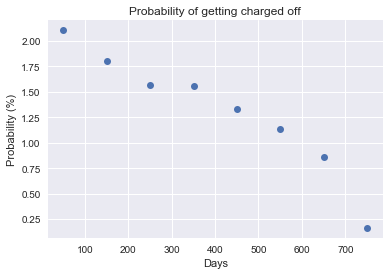

In [15]:
day_ranges = [[0, 100], [101, 200], [201, 300], [301, 400], [401, 500], [501, 600], [601, 700], [701, 800]]
x = [float(i + j) / 2  for i, j in day_ranges]
#print(x)

plt.plot(x, np_prob, linestyle='none', marker='o')
plt.xlabel('Days')
plt.ylabel('Probability (%)')
plt.title('Probability of getting charged off')
plt.show()

Now we can use a linear function to fit the probabilities and extroploate the probability in (801, 900), (901, 1000), and (1001, 1100) days.

In [16]:
z = np.polyfit(x, np_prob, 1)
#print(z)
print('The fitted function is y = %f x + %f' % (z[0], z[1]))

The fitted function is y = -0.002359 x + 2.260385


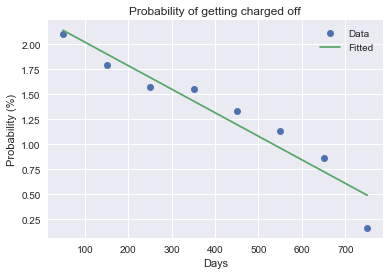

In [17]:
y = [z[0] * i + z[1] for i in x]

plt.plot(x, np_prob, linestyle='none', marker='o', label='Data')
plt.plot(x, y, label='Fitted')
plt.xlabel('Days')
plt.ylabel('Probability (%)')
plt.title('Probability of getting charged off')
plt.legend()
plt.show()

Let's extropolate the probabilities

In [18]:
prob_801_900_days = z[0] * ((801. + 900.) / 2) + z[1]
prob_901_1000_days = z[0] * ((901. + 1000.) / 2) + z[1]
prob_1001_1100_days = z[0] * ((1001. + 1100.) / 2) + z[1]
print(prob_801_900_days, prob_901_1000_days, prob_1001_1100_days)

0.2536695376254561 0.01772417191976894 -0.21822119378591864


We notice the probability for 1001 to 1100 days is negative. We know that if loans don't get charged off in their first thousand days, this means the financial condition of borrowers are good. Hence, there is very low possibility to get charged off in the rest 95 days (3 years is 1095 days) for these loans. So we can set the probability of getting charged off in 1001 to 1100 interval to zero. And the probabilities of getting charged for all intervals become:

In [19]:
new_prob = np.append(np_prob, [prob_801_900_days, prob_901_1000_days, 0.])
print(new_prob)

[2.106      1.79906487 1.57240825 1.55434822 1.33670693 1.13089005
 0.86228443 0.16286645 0.25366954 0.01772417 0.        ]


Now select the loans without charged-off

In [20]:
no_charged_off = df_loan['days_from_origination_to_chargeoff'].isnull()
df_no_charged_off = df_loan[no_charged_off]
df_no_charged_off.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46695 entries, 0 to 49999
Data columns (total 5 columns):
days_since_origination                46695 non-null int64
days_from_origination_to_chargeoff    0 non-null float64
remaining_days                        46695 non-null int64
days_from_charged_off                 46695 non-null float64
charged_off_interval                  46695 non-null float64
dtypes: float64(3), int64(2)
memory usage: 2.1 MB


In [21]:
df_no_charged_off.head()

,days_since_origination,days_from_origination_to_chargeoff,remaining_days,days_from_charged_off,charged_off_interval
0,109,NaN,986,0.0,0.0
1,679,NaN,416,0.0,0.0
2,723,NaN,372,0.0,0.0
3,509,NaN,586,0.0,0.0
4,254,NaN,841,0.0,0.0


Create a new column days_interval. If 0 <= days_since_origination <= 100, then assign 1 to days_interval. If the 101 <= days_since_origination <= 200, then assign 2 to days_intervel. Apply this step to all loans without charge-off.

In [22]:
df_no_charged_off['days_interval'] = df_no_charged_off['days_since_origination'].apply(interval)
df_no_charged_off.head()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,days_since_origination,days_from_origination_to_chargeoff,remaining_days,days_from_charged_off,charged_off_interval,days_interval
0,109,NaN,986,0.0,0.0,2
1,679,NaN,416,0.0,0.0,7
2,723,NaN,372,0.0,0.0,8
3,509,NaN,586,0.0,0.0,6
4,254,NaN,841,0.0,0.0,3


Group by days_interval, so we can know how many loans in each interval. For example, there are 6814 loans in interval 1 (0 to 100 days) and 6524 loans in interval 2 (201 to 300 days).

In [23]:
df_grouped = df_no_charged_off.groupby('days_interval').days_since_origination.count().reset_index()
df_grouped.rename(columns={'days_since_origination':'count'}, inplace=True)
df_grouped

,days_interval,count
0,1,6814
1,2,6524
2,3,6510
3,4,6414
4,5,6342
5,6,6161
6,7,6091
7,8,1839


We have the probability of getting charged-off np_prob for each interval. The number of loans in 0 to 100 days won't get charged off after finishing their 3-year terms are 6814 * (1 - np_prob[0]/100) * (100 - np_prob[1]/100) * ... * (1 - np_prob[10]/100). We can generalize the formula: $N_{loans} \times \Pi_{i=days\_interval - 1}^{10} (1 - np\_prob[i]/100)$. Because the unit in np_prob[i] is percentage, we have to divide 100.

In [24]:
def prob(i):
    #print(len(new_prob))
    probability = 1
    while i - 1 < len(new_prob):
        probability *= (1 - new_prob[i - 1]/100)
        i += 1
    return probability

df_grouped['Probability_no_charge_off'] = df_grouped['days_interval'].apply(prob)
df_grouped['No_charge_off'] = df_grouped['count'] * df_grouped['Probability_no_charge_off']
df_grouped['With_charge_off'] = df_grouped['count'] * (1 - df_grouped['Probability_no_charge_off'])
df_grouped

,days_interval,count,Probability_no_charge_off,No_charge_off,With_charge_off
0,1,6814,0.896917,6111.592826,702.407174
1,2,6524,0.916212,5977.370298,546.629702
2,3,6510,0.932998,6073.815199,436.184801
3,4,6414,0.947903,6079.847440,334.152560
4,5,6342,0.962869,6106.514957,235.485043
5,6,6161,0.975914,6012.606604,148.393396
6,7,6091,0.987077,6012.284951,78.715049
7,8,1839,0.995662,1831.022910,7.977090


Now let sum over all loans in With_charge_off column and get round off result.

In [25]:
sum = df_grouped['With_charge_off'].sum()
print(round(sum))

2490.0


Because we have 50000 loans and there are 3305 loans having charged off, the fraction of loans will have charged off after their 3-year terms finished are (2490+3305)/50000

In [26]:
print(num, den)
fraction = float(round(sum) + num) / den * 100
print('The fraction of loans will have charged off by the time all of their 3-year terms are finished is %.2f%%' % fraction)

3305 50000
The fraction of loans will have charged off by the time all of their 3-year terms are finished is 11.59%


# ANS: Fraction = 11.59%